In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [5]:
#Qini curve для оценки параметров
def qini_df(df):
    #Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['treatment'] == 0) #посчитаем всех кому не показали рекламу
    N_t = sum(ranked['treatment'] == 1) #посчитаем всех кому  показали рекламу
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[(ranked['treatment'] == 0) & (ranked['conversion' ] == 1),'n_c1'] = 1 #посчитаем всех кому не показали рекламу но конверсия состоялась
    ranked.loc[(ranked['treatment'] == 1) & (ranked['conversion' ] == 1),'n_t1'] = 1 #посчитаем всех кому показали рекламу и конверсия состоялась
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # Немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [6]:
df = pd.read_csv('criteo-uplift-v2.1.csv')

In [7]:
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


1. 0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float);
2. treatment: treatment group (1 = treated, 0 = control)
3. conversion: whether a conversion occured for this user (binary, label)
4. visit: whether a visit occured for this user (binary, label)
5. exposure: treatment effect, whether the user has been effectively exposed (binary) 

In [8]:
feature_cols = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
target_col = 'conversion'
treatment_col = 'treatment'

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[[treatment_col, target_col]], test_size=0.3)
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
9585027,18.877301,10.059654,8.704111,3.907662,10.280525,4.115453,-5.116672,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0,0,0
4766785,12.616365,10.059654,8.793879,4.679882,10.280525,4.115453,0.294443,4.833815,3.884971,13.190056,5.300375,-0.168679,1,0,0,0
4929950,22.281666,10.059654,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
5605255,23.146812,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
5799505,26.404830,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0


### S-learner

In [7]:
s_learner = BaseSClassifier(learner=CatBoostClassifier(verbose=0))

s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))


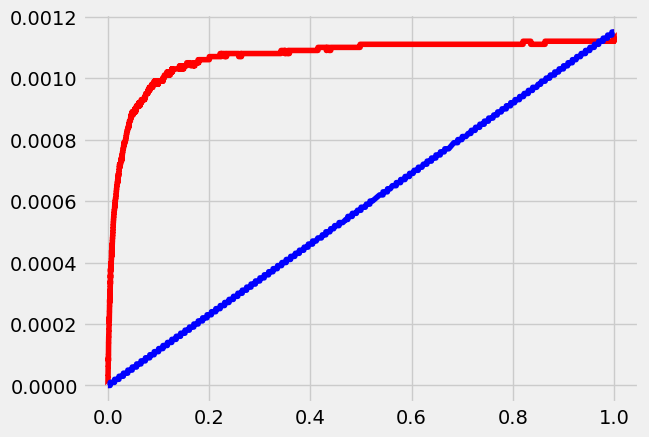

2060.5663700000005

In [8]:
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


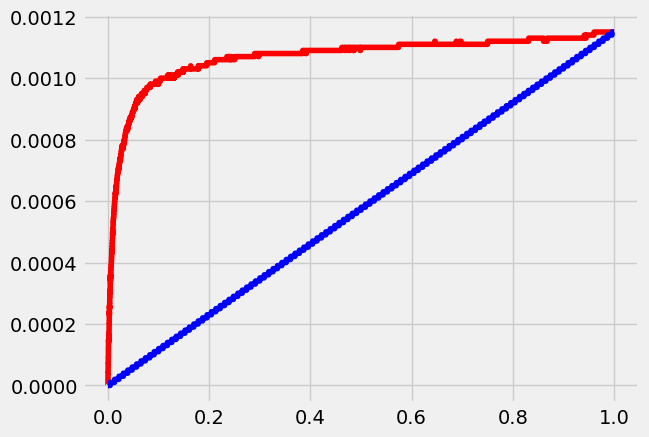

2062.9983100000004

In [9]:
from sklearn.linear_model import LogisticRegression

s_learner = BaseSClassifier(learner=LogisticRegression(verbose=0))
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

### T-learner

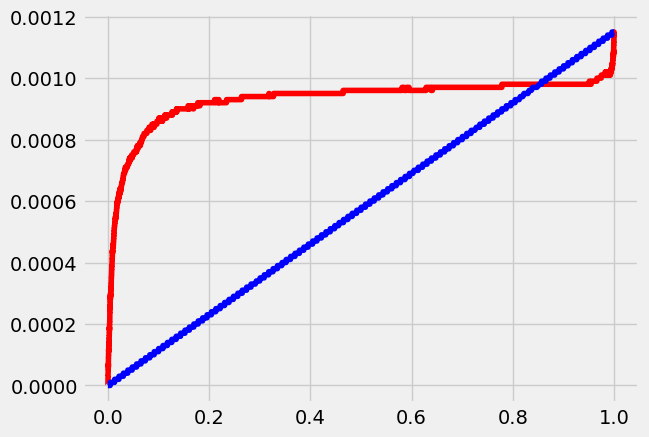

1488.5647299999996

In [10]:
t_learner = BaseTClassifier(learner=CatBoostClassifier(verbose=0))


t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score'] = uplift_vals
qini_df(df_test)

### Из-за размеров выборки и необходимых вычеслительных мощностей для подсчета, были сильно урезаны последующие модели. К сожалению мой ноутбук физически не способен просчитать их самостоятельно.

### X-learner

In [10]:
x, y = train_test_split(df_train, stratify=df_train[[treatment_col, target_col]], test_size=0.01)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

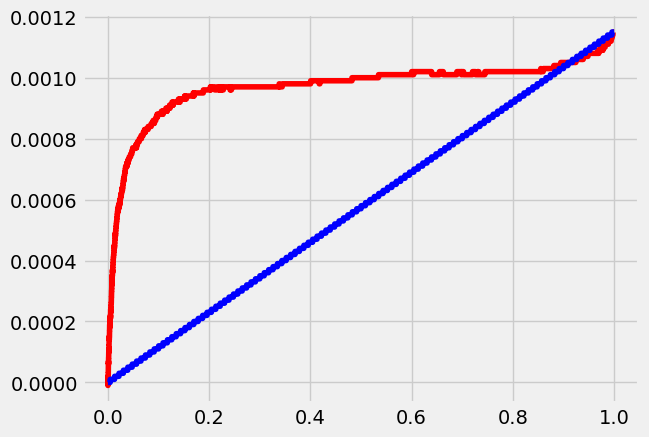

1654.260169999999

In [12]:
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(tol=0.1,solver='sag',n_jobs=-1),
                           effect_learner=LinearRegression(n_jobs=-1))


x_learner.fit(X=y[feature_cols],
              treatment=y[treatment_col],
              y=y[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score'] = uplift_vals
qini_df(df_test)

### R-learner

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

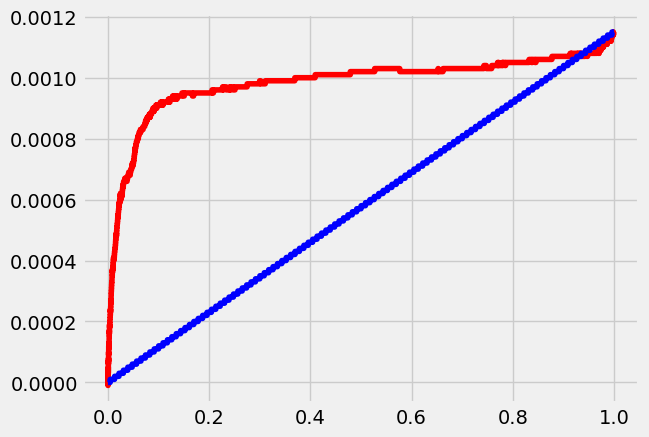

1712.1682500000006

In [13]:
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(tol=0.1,solver='sag',n_jobs=-1),
                            effect_learner=LinearRegression(n_jobs=-1))


r_learner.fit(X=y[feature_cols],
              treatment=y[treatment_col],
              y=y[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score'] = uplift_vals
qini_df(df_test)

### UpliftRandomForest

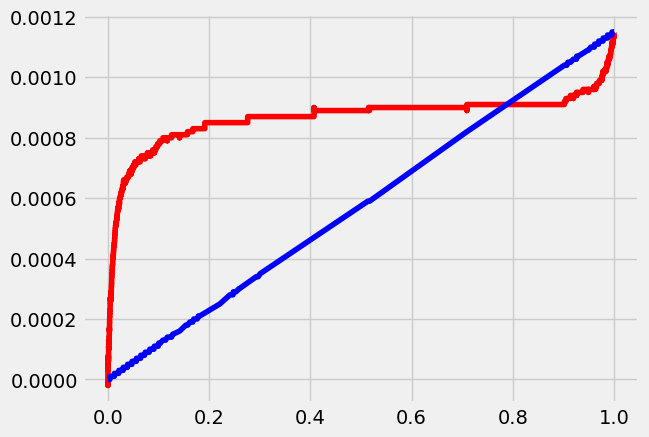

1203.1032299999915

In [11]:
uplift_model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(y[feature_cols].values,
                 treatment=y[treatment_col].apply(str).values,
                 y=y[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score'] = uplift_vals
qini_df(df_test)

#### S-learner показалсь лучший результат, но это лишь потому что данные для x,r learner'ов и UpliftRandomForest были сильно урезаны. Учитывая их результаты с настолько уменьшенной выборкой и ухудшенными в пользу производительности моделями, можно смело предположить что они покажут себя лучше чем нынешний фаворит в лице s-learner'а